In [20]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('default')

# 앙상블 학습과 랜덤 포레스트
집단 지성은 위대하다. 따라서 여러 예측기들로부터 예측을 수집하면 더 좋은 예측을 할 수 있다.  
실제로 예측기 각자가 랜덤 추측보다 조금 좋은 성능을 내더라도 합쳐놓으면 높은 정확도를 가지게 된다.  
이를 ***앙상블 학습*** 이라고 하며 여러 DecisionTree를 앙상블 방식으로 이용하는 방식을 ***랜덤 포레스트*** 라고 부른다.  
밑의 예시를 통하여 투표 기반 분류기의 성능을 확인해보자

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='soft')

# 모든 분류기가 클래스의 확률을 예측할 수 있다면 (predict_proba()가 있다면) 개별 분류기의 예측을 평규내어
# 가장 높은 클래스를 예측할 수 있다. 이를 간접 투표 (soft voting)이라고 부르고 성능이 직접 투표보다 높다.

In [22]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [23]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 배깅과 페이스팅
같은 알고리즘을 지닌 다수의 분류기들을 훈련 셋의 서브셋을 무작위로 구성하여 다르게 학습시키는 방식이 있다.  
중복을 허용하면 ***배깅 (bagging, bootstrap aggregating, bootstrapping)***  
중복을 허용하지 않으면 ***페이스팅 (pasting)*** 이라고 한다.  
모든 예측기가 훈련을 마치면 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.  
수집 함수는 분류 문제의 경우 통계적 최빈값 (statistical mode)이고 회귀의 경우에는 평균을 계산한다.  
개별 예측기는 원본 훈련 셋으로 훈련한 것보다 편향이 훨씬 많이 되어있지만 수집 함수를 통과하면 편향과 분산이 감소한다.  

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                            n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


배깅을 사용하면 어떤 샘플은 여러 번 이용되고, 어떤 샘플을 이용되지 않을 수 있다.  
중복을 허용하면 훈련 셋 m개의 샘플 중 대략 63% 정도만 샘플링이 된다.  
선택되지 않은 남은 37%를 ***oob (out-of-bag)*** 라고 부른다.  
따라서 따로 검증 셋을 만들지 않고도 oob를 이용하여 쉽게 모델을 평가할 수 있다.

In [25]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            bootstrap=True,
                            n_jobs=-1, # 모든 CPU 코어를 이용하여 훈련을 진행한다.
                            oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [26]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

oob 샘플에 대한 DecisionFunction의 값도 oob_dicision_function_ 변수에서 확인할 수 있다.  
이 경우, 결정 함수는 각 훈렴 샘플의 클래스 확률을 반환한다. (predict_proba()를 가지고 있기 때문)

In [27]:
bag_clf.oob_decision_function_

array([[0.43069307, 0.56930693],
       [0.40677966, 0.59322034],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.05050505, 0.94949495],
       [0.37209302, 0.62790698],
       [0.01470588, 0.98529412],
       [0.99411765, 0.00588235],
       [0.97311828, 0.02688172],
       [0.72959184, 0.27040816],
       [0.00555556, 0.99444444],
       [0.77894737, 0.22105263],
       [0.8       , 0.2       ],
       [0.97727273, 0.02272727],
       [0.04945055, 0.95054945],
       [0.00518135, 0.99481865],
       [0.97740113, 0.02259887],
       [0.9040404 , 0.0959596 ],
       [1.        , 0.        ],
       [0.02824859, 0.97175141],
       [0.33142857, 0.66857143],
       [0.91891892, 0.08108108],
       [1.        , 0.        ],
       [0.97087379, 0.02912621],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.00512821, 0.99487179],
       [0.62244898, 0.37755102],
       [0.

## 랜덤 패치와 랜덤 서브스페이스
특성 샘플링을 통해 고차원의 데이터셋을 다룰 때 유용하게 사용할 수 있다.  
특히 더 다양한 예측기를 만들 수 있고 편향을 늘리지만 분산을 낮춘다.  
max_features, bootstrap_features 두 매개변수로 조절되며 무작위로 선택된 입력 특성의 일부분으로 훈련한다.  
만약 샘플과 특성 보두 샘플링하면 랜덤 패치 방식 (random patches method) 이라고 하며  
훈련 샘플을 모두 이용하지만 (bootstrap=False, max_samples=1.0) 특성은 샘플링 한다면  
랜덤 서브스페이스 방식 (random space method) 이라고 한다.<br>

## 랜덤 포레스트
랜덤 포레스트는 일반적인 배깅(or 페이스팅) 을 적용한 DecisionTree 의 앙상블이다.  
랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성보다는 무작위로 선정된 특성 중에서
<br>최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 이로인해 편향에서 손해를 보지만 분산을 낮추어 더 좋은 모델이 탄생.
max_samples를 훈련 세트의 크기로 지정한다.

In [28]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.92


 ### 엑스트라 트리
 각 노드는 무작위로 특성의 서브셋을 만들지만 더한 무작위성을 위하여 최적의 임곗값을 찾기보다  
 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다.  
 이와 같은 극단적인 무작위성을 가진 랜덤 포레스트를 ***익스트림 랜덤 트리, 엑스트라 트리*** 라고 부른다.

In [29]:
from sklearn.ensemble import ExtraTreesClassifier # RandomForestClassifier 와 사용법은 동일
from sklearn.ensemble import ExtraTreesRegressor  # RandomForestRegressor 와 사용법은 동일

### 특성 중요도
랜덤 포레스트는 특성의 상대적 중요도를 파악하기가 용이하다.  
사이킷런의 랜덤 포레스트는 어떤 특성을 사용한 노드가 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다.<br>
더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.  
사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도 전체 합이 1이 되도록 정규화를 진행한다.

In [30]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## 부스팅
성능이 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 학습을 부스팅이라고 한다.  
앞의 모델을 보완해 나가면서 전체적인 예측기를 학습시키는 것인데 에이다 부스트와 그레디언트 부스트가 있다.

### 에이다부스트
이전 모델이 과소적합됬던 훈련 샘플의 가중치를 높인다면 문제점을 보완해 나갈 수 있다.  
경사 하강법과 비슷해보이지만 에이다부스트는 비용 함수를 최소화하기 위해 파라미터를 조절하기보단,  
틀린 샘플의 가중치가 높아진 예측기를 모델에 추가함으로써 보완해 나간다.  
<br>
우선 각 샘플 가중치 $w^{(i)} 는 초기에 \frac{1}{m}$ 으로 초기화 되어있다.  
그리고 j번째 예측기의 각 가중치를 이용한 예측기의 에러율 $r_{j}$는 다음과 같이 계산된다.<br>
\begin{equation}
    r_{j} = \frac{\sum^{m}_{i=1}w^{(i)}\; (where\; \hat{y}_{j}^{(i)} \neq y^{(i)})}{\sum^{m}_{i=1}w^{(i)}}
\end{equation}<br>
즉, 전체 가중치에 대한 오답이 발생한 샘플의 가중치 비율이 j번째 예측기에 대한 에러율이 된다.  
그리고 j번째 예측기의 가중치 $\alpha_{j}$는 이 에러율을 이용하여 계산된다.
\begin{equation}
    \alpha_{j}=\eta\log{\frac{1-{r_{j}}}{r_{j}}}
\end{equation}
 그다음 에이다부스트 알고리즘이 다음 식을 이용하여 i번째 샘플의 샘플의 가중치를 업데이트한다.
 \begin{equation}
     w^{(i)}=
     \begin{cases}
         w^{(i)}\; (where\; \hat{y}_{j}^{(i)} = y^{(i)})\\
         w^{(i)}exp(\alpha_{j})\; (where\; \hat{y}_{j}^{(i)} \neq y^{(i)})
     \end{cases}
 \end{equation}<br>
 그런 다음 모든 샘플의 가중치를 정규화 하기 위하여 $\sum^{m}_{i=1}w^{(i)}$ 으로 나눈다.
 <br>
 이 과정을 전체 예측기의 개수가 지정한 개수에 도달할 때 혹은 완벽한 예측기가 만들어 질 때 까지 반복한다.  
 예측을 할 때는 단순히 모든 예측기의 예측을 계산하고 예측기의 가중치 $\alpha_{j}$를 더하여 구한다.  
 이중 최대값을 가지는 클래스를 선택함으로써 예측과정을 마무리 한다.
 \begin{equation}
     \hat{y}(x) = \textrm{argmax}_{k} \sum^{N}_{j=1}\alpha_{j} \;(where\; \hat{y}(x)=k)
 \end{equation}

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5)
# 사이킷런에서는 SAMME 라는 에이다부스트의 다중 클래스 버전을 이용한다.
# 만약 클래스의 확률을 추정할 수 있다면 (predict_proba()) SAMME.R 을 이용 가능하며 성능이 일반적으로 좋다.

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 그레디언트 부스팅
에이다부스팅과 마찬가지로 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하지만  
샘플의 가중치 대신, 이전 예측가 마든 잔여 오차(residual error)에 새로운 예측기를 학습시킨다.  
(참고로 모집단에서 얻은 회귀식으로 낸 예측값과 실제값의 차이가 오차이고 표본에서 얻었다면 잔차가 된다)  

In [32]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X) # 정답과 예측값의 차이를 y2에 저장한다.

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2) # 다음 예측기는 이전 예측기의 잔차를 학습한다.
y3 = y2 - tree_reg2.predict(X) # 또다시 발생한 잔차를 저장해주고...

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3) # 계속해서 이전 예측기의 잔차를 학습시키자.

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [34]:
# 그레디언트부스트는 사이킷런에 이미 구현되어있다.
# DecisionTree와 같은 파라미터가 존재한다.
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=200,
                                 learning_rate=0.1)

# 참고로 학습률이 적을수록 많은 트리가 필요하지만 성능이 좋아진다.

gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200)

조기 종료를 이용하여 최적의 트리의 수를 찾을 수 있다.  
간단하게 staged_predict() 메서드를 이용하면 훈련의 각 단계에서 만들어진 예측기를 순회하는 iterator를 반환한다.  
아래 코드는 120개의 트리로 GBRT를 훈련시키고 최적의 트리수를 찾기 위해 검증 오차를 측정한다.

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=120,
                                 random_state=42)
gbrt.fit(X_train, y_train)

errors = [
    mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)
]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

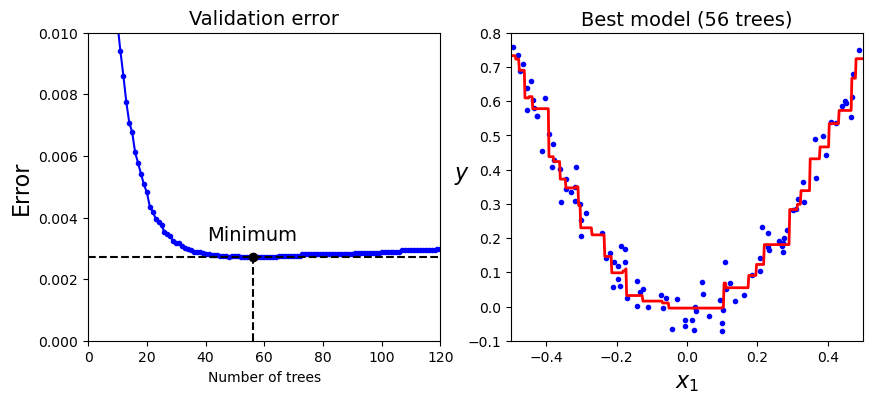

In [36]:
def plot_predictions(regressors,
                     X,
                     y,
                     axes,
                     label=None,
                     style="r-",
                     data_style="b.",
                     data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)


min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators,
         min_error * 1.2,
         "Minimum",
         ha="center",
         fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

여기서는 120개의 트리를 훈련시키고 최적의 수를 찾았지만 실제로 훈련을 중지시키는 방식도 있다.  
warm_start를 True로 두면 사이킷런이 fit()을 실행할 때 기존 트리를 유지시키며 훈련을 진행한다.  
이때 검증 오차가 향상되지 않으면 훈련을 종료시킴으로서 조기 종료를 구현한다.

In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error: # 오차가 향상된다면 error_going_up을 줄여준다.
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1 # 오차가 향상되지 않는다면 error_going_up을 하나 늘려준다.
        if error_going_up == 5: # 만약 5번 향상되지 않았다면 조기종료
            break  # early stopping

print(gbrt.n_estimators)

61
